## Ejemplo de filtro de imagen

En este ejemplo se ha optado para aplicar 2 multidimensiones en GPU. El ejemplo modifica el color de una imagen parametrizada a escala de grises. El cálculo de la escala se realiza convirtiendo los 3 canales RGB, que representan a los colores R (*rojo*)-G(*verde*)-B(*azul*), de cada pixel siguiendo la ecuación:

<center>$ Pixel=R*0.30+G*0.59+B*0.11$</center>

EL objetivo es enseñar el funcionamiento del Lenguaje Python, CUDA y el manejo de imágenes a bajo nivel. El ejemplo es ilustrativo, ya que internamente el módulo Pillow posee varios filtros integrados

f) Mida el tiempo de respuesta que tiene el algoritmo con la dimension X en su maxima capacidad y el resto en 1. Luego modifique la configuración para que la dimension Y tenga su maxima capacidad y el resto en 1. Compare los resultado. 
¿A que cree que se debe la diferencia de tiempo?

g) ¿Qué cambios realizaría para que solo se procese la parte derecha de la imagen? ¿Qué sucede con la parte izquierda en la imagen resultante? ¿Qué sucede con la velocidad de respuesta?

---
# 2 Armado del ambiente
Toma la dirección web de una imagen con acceso público en internet, la deja disponible al contexto de ejecución del cuaderno Colab.

In [ ]:
#@title # 2.1 Parámetros de ejecución
#@markdown ---
#@markdown ### Especifique la URL de la imagen:
url_imagen = "https://raw.githubusercontent.com/soa-pc-unlam/ProgramacionConcurrente/main/Enunciados%20TPs/TP-GPU/MesiCopa.jpg" #@param {type:"string"}

#@markdown ---
# Leo la imagen desde internet.
#!wget https://github.com/wvaliente/SOA_HPC/blob/main/unlam.jpg?raw=true -O imagen.jpg

# TODO: Mejorar informaciòn y resutlado de ejecución. 
!wget {url_imagen} -O imagen.jpg




--2023-02-05 16:33:21--  https://raw.githubusercontent.com/soa-pc-unlam/ProgramacionConcurrente/main/Enunciados%20TPs/TP-GPU/MesiCopa.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 209591 (205K) [image/jpeg]
Saving to: ‘imagen.jpg’

imagen.jpg          100%[===================>] 204.68K  --.-KB/s    in 0.003s  

2023-02-05 16:33:22 (61.2 MB/s) - ‘imagen.jpg’ saved [209591/209591]



---
## 2.2 Instala en el cuaderno el módulo CUDA de Python.

In [ ]:
!pip install pycuda 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 15.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 KB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 10.5 MB/s eta 0:00:00
  Created wheel for pycuda: filename=pycuda-2022.2.2-cp38-cp38-linux_x86_64.whl size=661775 sha256=e1702b311f8361165f607b86ecb17577cfad220b9e39a8ae391d46fe6e0ed0a3
  Stored in directory: /root/.cache/pip/wheels/7b/41/0d/7cecb04af969d283ebe4a69579a8b2baec0d010a1ac4159f7e
  Created wheel for pytools: filename=pytools-2022.1.14-py2.py3-none-any.whl size=69870 sha256=ddac277c7d4c62ea06ec7991016f27f5fde7d059b66781900906e8e206b1a384
  Stored in directory: /root/.cache/pip/wheels/cb/fc/a

---
# 3 Desarrollo
Ejecución del algoritmo escala de grises en GPU.

Imagen del filtro:  imagen.jpg  - tipo  RGB - [ 1024 ,  768 ]


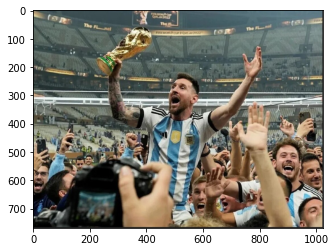

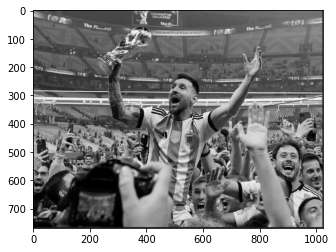

In [ ]:
#Comentar esta linea para mostrar las imagenes
#%%writefile filter_image.py 

#Comentar esta linea para medir los tiempos
%matplotlib inline

import matplotlib.pyplot as plt
import numpy
from PIL import Image 
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

# -----------------------------------------------------------------------------
img_nombre = 'imagen.jpg'
image = Image.open( img_nombre ) 
  
# summarize some details about the image 
img_ancho, img_alto  = image.size 

# -----------------------------------------------------------------------------
img_O_cpu = numpy.asarray(image)
img_O_cpu = img_O_cpu.astype( numpy.int32() )
img_R_cpu = numpy.empty_like( img_O_cpu)

img_O_gpu = cuda.mem_alloc( img_O_cpu.nbytes )
img_R_gpu = cuda.mem_alloc( img_R_cpu.nbytes )

cuda.memcpy_htod( img_O_gpu, img_O_cpu )
cuda.memcpy_htod( img_R_gpu, img_R_cpu )

# -----------------------------------------------------------------------------

module = SourceModule("""
#define PIXEL_ROJO( x,y) (x+(y*ancho))*3
#define PIXEL_VERDE(x,y) PIXEL_ROJO(x,y) + 1
#define PIXEL_AZUL( x,y) PIXEL_ROJO(x,y) + 2

__global__ void kernel_img( int ancho, int alto, int *img_O, int *img_R )
{
  // Calculo las coordenadas del Thread en dos dimensiones.
  int idx = threadIdx.x + blockIdx.x*blockDim.x;
  int idy = threadIdx.y + blockIdx.y*blockDim.y;
  float fGris = 0.0;

  // Verifico que los Thread, esten dentro de las dimensiones de la imagen.
  if( idx < ancho && idy < alto )
  {
    // Calculo el color gris para el pixel a partir de los componentes.
    fGris = (float)img_O[ PIXEL_ROJO(  idx, idy ) ]*0.29;  // Componente Rojo del pixel.
    fGris +=(float)img_O[ PIXEL_VERDE( idx, idy ) ]*0.59;  // Componente Verde del pixel.
    fGris +=(float)img_O[ PIXEL_AZUL(  idx, idy ) ]*0.11;  // Componente Azul del pixel.
    // Escribo el color del pixel.
    img_R[ PIXEL_ROJO(  idx, idy ) ] = (int) fGris;
    img_R[ PIXEL_VERDE( idx, idy ) ] = (int) fGris;
    img_R[ PIXEL_AZUL(  idx, idy ) ] = (int) fGris;
  }
}
""") 

# -----------------------------------------------------------------------------
kernel = module.get_function("kernel_img")

dim_hilo_x = 8
dim_bloque_x = int( (img_ancho+dim_hilo_x-1) / dim_hilo_x )

dim_hilo_y = 8
dim_bloque_y = int( (img_alto+dim_hilo_y-1) / dim_hilo_y )

# -----------------------------------------------------------------------------
kernel( numpy.int32(img_ancho), numpy.int32(img_alto), img_O_gpu, img_R_gpu, 
        block=( dim_hilo_x, dim_hilo_y, 1 ), 
        grid=(dim_bloque_x, dim_bloque_y,1) )



# -----------------------------------------------------------------------------
cuda.memcpy_dtoh( img_R_cpu, img_R_gpu )


# -----------------------------------------------------------------------------
# Muestro los atributos de la imagen y como se ve antes del seudo filtro.
print("Imagen del filtro: ", img_nombre , " - tipo " , image.mode , "- [" , img_ancho , ", " , img_alto , "]" )  
# -----------------------------------------------------------------------------
# Muestro la imagen Original el filtro.
plt.figure()
imgplot=plt.imshow( img_O_cpu )

# Muestro la imagen luego de aplicarle el filtro.
plt.figure()
imgplot=plt.imshow( img_R_cpu )



## 3.1 Ejecución y profiling del script 

Uitlizando nvprof se ejecuta el script y se miden los tiempos de ejecución.

In [ ]:
!nvprof python filter_image.py

==37373== NVPROF is profiling process 37373, command: python3 filter_image.py
Imagen del filtro:  imagen.jpg  - tipo  RGB - [ 1024 ,  768 ]
Grilla : [ 1024 , 1 ], Bloques: [ 1 , 768  ] 
Total de Thread: [ 1024 , 768  ]  =  786432
==37373== Profiling application: python3 filter_image.py
==37373== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   55.18%  6.5582ms         1  6.5582ms  6.5582ms  6.5582ms  [CUDA memcpy DtoH]
                   39.46%  4.6900ms         2  2.3450ms  2.1788ms  2.5112ms  [CUDA memcpy HtoD]
                    5.36%  637.33us         1  637.33us  637.33us  637.33us  kernel_img
      API calls:   77.74%  257.99ms         1  257.99ms  257.99ms  257.99ms  cuCtxCreate
                   17.53%  58.178ms         1  58.178ms  58.178ms  58.178ms  cuCtxDetach
                    2.69%  8.9408ms         1  8.9408ms  8.9408ms  8.9408ms  cuMemcpyDtoH
                    1.62%  5.3804ms         2  2.6902ms

---
# 6 Bibliografía

[1] MARKDOWN SYNTAX Colab: [PDF](https://github.com/wvaliente/SOA_HPC/blob/main/Documentos/markdown-cheatsheet-online.pdf)

[2] Introducción a Python: [Página Colab](https://github.com/wvaliente/SOA_HPC/blob/main/Documentos/Python_Basico.ipynb) 

[3] Tutorial Point Colab: [PDF](https://github.com/wvaliente/SOA_HPC/blob/main/Documentos/markdown-cheatsheet-online.pdf)


